In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-11-06 09:41:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   177MB/s    in 1.1s    

2021-11-06 09:41:03 (177 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-11-06 09:41:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.69.128, 64.233.181.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp

In [2]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [3]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock03-019.png', 'rock04-011.png', 'rock02-057.png', 'rock04-094.png', 'rock06ck02-037.png', 'rock03-097.png', 'rock06ck02-036.png', 'rock02-049.png', 'rock03-044.png', 'rock05ck01-069.png']
['paper07-077.png', 'paper07-040.png', 'paper06-059.png', 'paper01-104.png', 'paper02-042.png', 'paper04-039.png', 'paper05-013.png', 'paper03-037.png', 'paper04-027.png', 'paper07-093.png']
['testscissors01-018.png', 'testscissors02-097.png', 'scissors02-055.png', 'scissors01-118.png', 'testscissors02-073.png', 'scissors02-054.png', 'scissors03-001.png', 'testscissors01-112.png', 'testscissors03-031.png', 'testscissors03-018.png']


/tmp/rps/rock/rock03-019.png


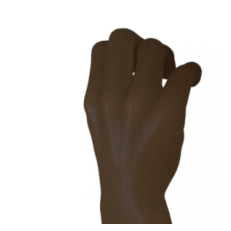

/tmp/rps/rock/rock04-011.png


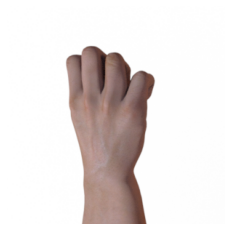

/tmp/rps/paper/paper07-077.png


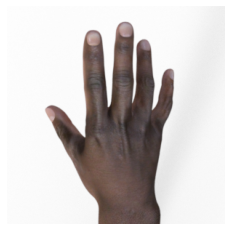

/tmp/rps/paper/paper07-040.png


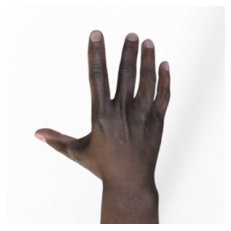

/tmp/rps/scissors/testscissors01-018.png


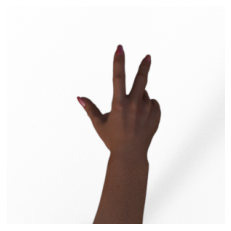

/tmp/rps/scissors/testscissors02-097.png


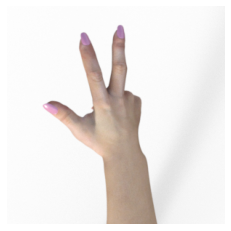

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=20, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
79/79 [==============================] - 188s 2s/step - loss: 1.2570 - accuracy: 0.3623 - val_loss: 0.9489 - val_accuracy: 0.3522
Epoch 2/20
79/79 [==============================] - 187s 2s/step - loss: 0.9111 - accuracy: 0.5556 - val_loss: 0.5407 - val_accuracy: 0.6478
Epoch 3/20
79/79 [==============================] - 190s 2s/step - loss: 0.6011 - accuracy: 0.7528 - val_loss: 0.0932 - val_accuracy: 0.9839
Epoch 4/20
79/79 [==============================] - 193s 2s/step - loss: 0.3985 - accuracy: 0.8512 - val_loss: 0.2018 - val_accuracy: 0.9489
Epoch 5/20
79/79 [==============================] - 191s 2s/step - loss: 0.2875 - accuracy: 0.8905 - val_loss: 0.3081 - val_accuracy: 0.8737
Epoch 6/20
79/79 [==============================] - 190s 2s/step - loss: 0.2370 - accuracy: 0.9115 - val_loss: 0.0433 - val_accuracy: 0.9892
Epoch 7/20
79/79 [==============================] - 189s 2s/step - loss: 0.1770 - accuracy: 0.9409 - val_loss: 0.0317 - val_accuracy: 0.9892
Epoch 8/20
79

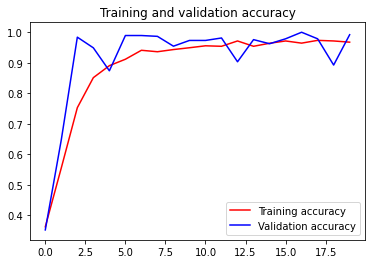

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving Scissor45.jpg to Scissor45.jpg
Scissor45.jpg
[[0. 0. 1.]]
